In [1]:
import json
import pandas as pd
import numpy as np
import urllib3
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
%matplotlib inline
sns.set_style("whitegrid")

# import local modules
import getpbp
import getdata as gd
from BasketballCourt import get_layout

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',  None)
%load_ext autoreload
%autoreload 2
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import joblib

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
all_player_shots = pd.read_csv('new_data/all_player_shots.csv')

In [3]:
all_player_shots.shape

(2983, 19)

In [4]:
all_player_shots.head()

,height,name,position,shotType,ACTIONTYPE,EVENTMSGTYPE,eventType,HOMEDESCRIPTION,VISITORDESCRIPTION,gameClock,shotClock,period,x,y,closest_opponent_dist,game_id,Team,closest_opponent,opponent_strength
0,81.0,Al Horford,F-C,2PT_SHOT,2PT,score,SHOT,Horford 15' Jump Shot (4 PTS) (Tatum 3 AST),NaN,303.32,10.2,2.0,-27.89,6.74,6.20,42100406,home,Klay Thompson,0.0359
1,81.0,Al Horford,F-C,3PT_SHOT,3PT,miss,SHOT,MISS Horford 27' 3PT Jump Shot,NaN,661.04,16.6,3.0,16.43,1.74,4.96,42100406,home,Andrew Wiggins,0.0567
2,81.0,Al Horford,F-C,3PT_SHOT,3PT,score,SHOT,Horford 25' 3PT Jump Shot (7 PTS) (Smart 5 AST),NaN,585.68,13.0,3.0,43.06,-23.07,9.29,42100406,home,Otto Porter Jr.,0.0134
3,81.0,Al Horford,F-C,3PT_SHOT,3PT,score,SHOT,Horford 24' 3PT Jump Shot (10 PTS) (Tatum 4 AST),NaN,482.04,10.9,3.0,38.34,23.42,6.19,42100406,home,Draymond Green,0.0540
4,81.0,Al Horford,F-C,3PT_SHOT,3PT,score,SHOT,Horford 28' 3PT Jump Shot (13 PTS) (Tatum 5 AST),NaN,414.68,11.1,3.0,24.33,-19.77,4.91,42100406,home,Draymond Green,0.0540


In [5]:
all_player_shots.isna().sum()

height                      0
name                        0
position                    0
shotType                    0
ACTIONTYPE                  0
EVENTMSGTYPE                0
eventType                   0
HOMEDESCRIPTION          1396
VISITORDESCRIPTION       1412
gameClock                   0
shotClock                   0
period                      0
x                           0
y                           0
closest_opponent_dist       0
game_id                     0
Team                        0
closest_opponent            0
opponent_strength           0
dtype: int64

In [6]:
all_player_shots.dtypes

height                   float64
name                      object
position                  object
shotType                  object
ACTIONTYPE                object
EVENTMSGTYPE              object
eventType                 object
HOMEDESCRIPTION           object
VISITORDESCRIPTION        object
gameClock                float64
shotClock                float64
period                   float64
x                        float64
y                        float64
closest_opponent_dist    float64
game_id                    int64
Team                      object
closest_opponent          object
opponent_strength        float64
dtype: object

In [7]:
all_player_shots.describe()

,height,gameClock,shotClock,period,x,y,closest_opponent_dist,game_id,opponent_strength
count,2983.000000,2983.000000,2983.000000,2983.000000,2983.000000,2983.000000,2983.000000,2.983000e+03,2983.000000
mean,77.639625,354.062923,11.630439,2.455582,0.695313,-0.016363,4.670074,4.210034e+07,0.034237
std,2.380729,208.731377,5.655485,1.112677,33.401902,12.561527,2.686837,4.556770e+01,0.017067
min,72.000000,0.120000,0.000000,1.000000,-45.340000,-24.400000,0.830000,4.210030e+07,0.000300
25%,76.000000,172.020000,7.700000,1.000000,-34.805000,-6.190000,2.900000,4.210030e+07,0.022100
50%,78.000000,353.600000,11.900000,2.000000,14.020000,-0.140000,4.140000,4.210031e+07,0.035900
75%,79.000000,536.060000,15.750000,3.000000,36.210000,6.110000,5.600000,4.210040e+07,0.048600
max,86.000000,715.840000,24.000000,4.000000,44.870000,24.350000,38.670000,4.210041e+07,0.066400


In [8]:
all_player_shots = all_player_shots.drop(columns = ['ACTIONTYPE', 'eventType', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION'])

In [10]:
all_player_shots.head()

,height,name,position,shotType,score_miss,gameClock,shotClock,period,x,y,closest_opponent_dist,game_id,Team,closest_opponent,opponent_strength
0,81.0,Al Horford,F-C,2PT_SHOT,score,303.32,10.2,2.0,-27.89,6.74,6.20,42100406,home,Klay Thompson,0.0359
1,81.0,Al Horford,F-C,3PT_SHOT,miss,661.04,16.6,3.0,16.43,1.74,4.96,42100406,home,Andrew Wiggins,0.0567
2,81.0,Al Horford,F-C,3PT_SHOT,score,585.68,13.0,3.0,43.06,-23.07,9.29,42100406,home,Otto Porter Jr.,0.0134
3,81.0,Al Horford,F-C,3PT_SHOT,score,482.04,10.9,3.0,38.34,23.42,6.19,42100406,home,Draymond Green,0.0540
4,81.0,Al Horford,F-C,3PT_SHOT,score,414.68,11.1,3.0,24.33,-19.77,4.91,42100406,home,Draymond Green,0.0540


In [11]:
all_player_shots['closest_opponent_dist'] = all_player_shots['closest_opponent_dist'].round(1)

In [12]:
all_player_shots['score_miss'].value_counts()

score_miss
miss     1646
score    1337
Name: count, dtype: int64

In [13]:
all_player_shots['shotType'].value_counts()

shotType
2PT_PAINT           1179
3PT_SHOT             868
3PT_DRIBBLE SHOT     451
2PT_DRIBBLE SHOT     402
2PT_SHOT              83
Name: count, dtype: int64

In [14]:
all_player_shots['period'].value_counts()

period
1.0    783
3.0    756
2.0    751
4.0    693
Name: count, dtype: int64

In [15]:
all_player_shots['position'].value_counts()

position
G      1221
F       764
G-F     742
F-C     240
C        16
Name: count, dtype: int64

In [16]:
all_player_shots['name'].value_counts()

name
Jaylen Brown             237
Jayson Tatum             237
Stephen Curry            227
Andrew Wiggins           178
Klay Thompson            177
Marcus Smart             154
Jimmy Butler             130
Luka Doncic              118
Jordan Poole             106
Derrick White            105
Al Horford                88
Bam Adebayo               79
Draymond Green            79
Jalen Brunson             69
Max Strus                 66
Victor Oladipo            62
Grant Williams            58
Payton Pritchard          56
Kevon Looney              56
Robert Williams III       53
Gabe Vincent              52
Kyle Lowry                49
Spencer Dinwiddie         49
Reggie Bullock            47
Tyler Herro               43
Dorian Finney-Smith       42
P.J. Tucker               39
Caleb Martin              37
Duncan Robinson           33
Otto Porter Jr.           30
Maxi Kleber               26
Gary Payton II            22
Davis Bertans             18
Jonathan Kuminga          16
Moses Moo

In [17]:
all_player_shots.columns

Index(['height', 'name', 'position', 'shotType', 'score_miss', 'gameClock',
       'shotClock', 'period', 'x', 'y', 'closest_opponent_dist', 'game_id',
       'Team', 'closest_opponent', 'opponent_strength'],
      dtype='object')

In [18]:
cat_col = ['shotType', 'period', 'Team', 'position']

In [19]:
num_col =['gameClock', 'shotClock', 'x', 'y', 'closest_opponent_dist', 'height', 'opponent_strength']

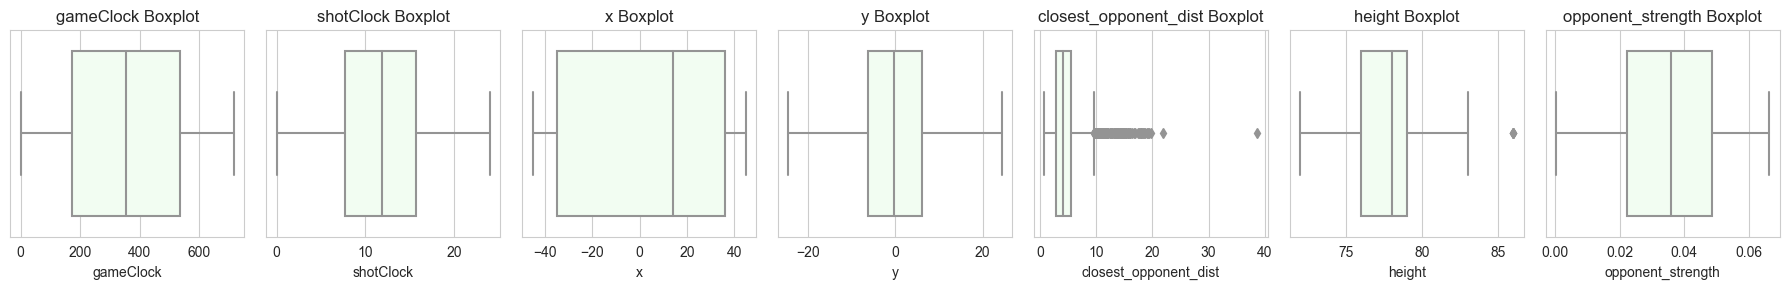

In [20]:
fig, axes = plt.subplots(1, 7, figsize=(18, 3))
for idx, col in enumerate(num_col):
    sns.boxplot(x=col, data=all_player_shots, color = 'honeydew', ax=axes[idx])
    axes[idx].set_title(col + ' Boxplot')
plt.tight_layout()
plt.show()

In [24]:
def remove_outliers(df, column_name, threshold=1.5):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    filtered_df = df.loc[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return filtered_df

In [25]:
all_player_shots_2 = remove_outliers(all_player_shots, 'closest_opponent_dist')

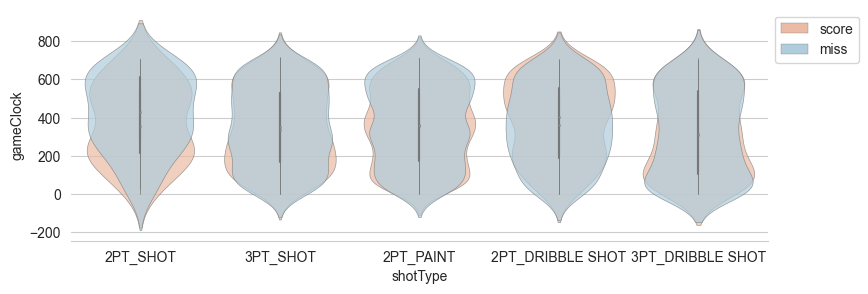

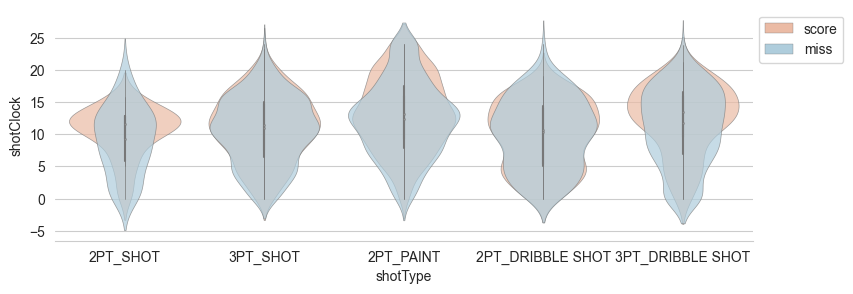

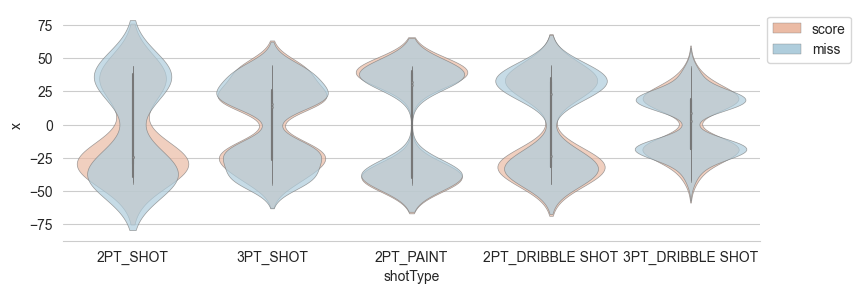

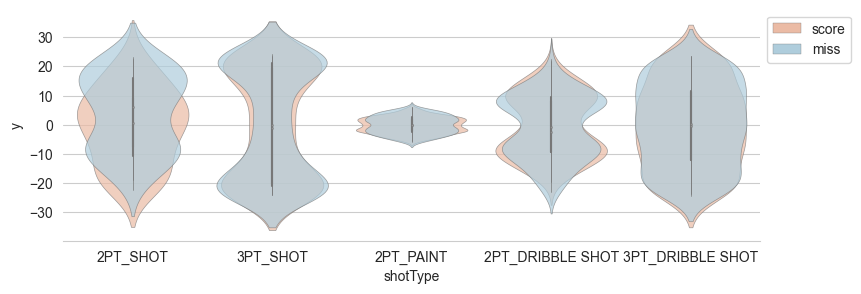

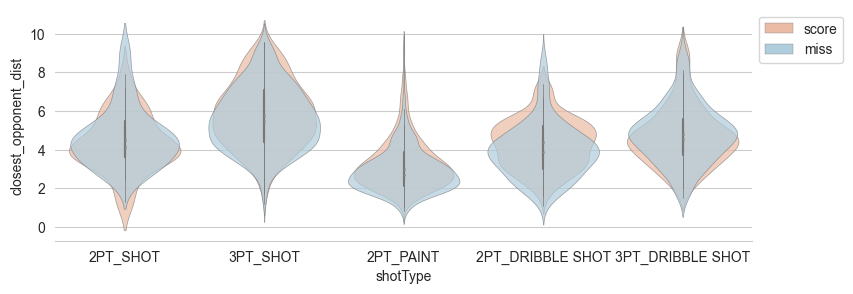

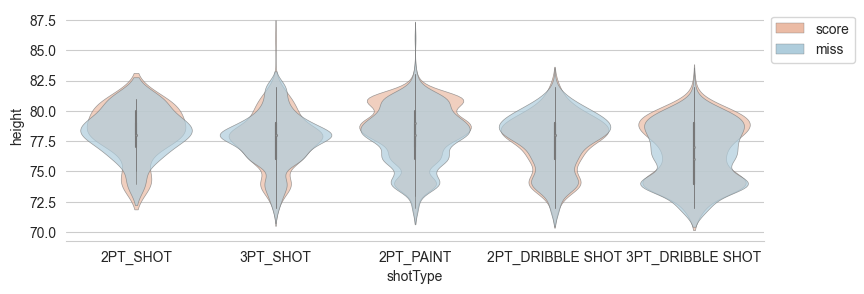

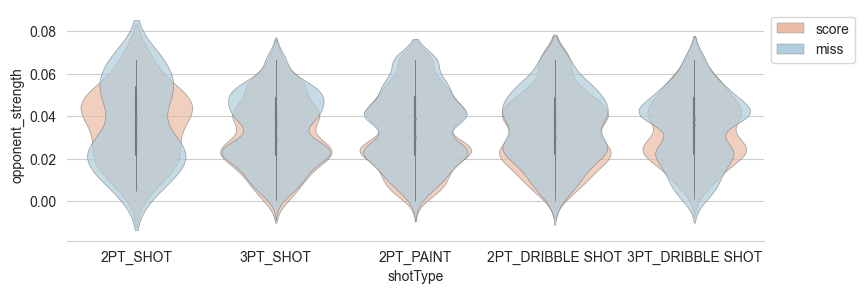

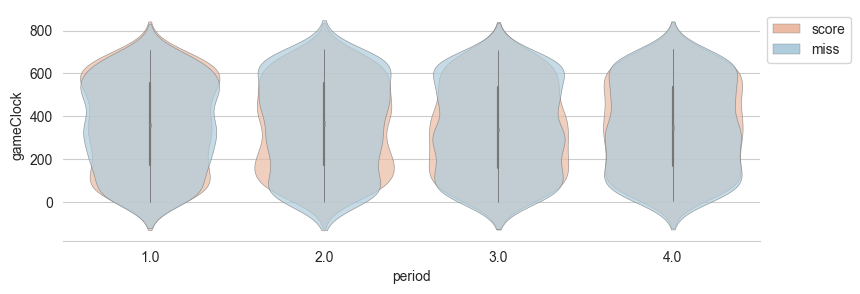

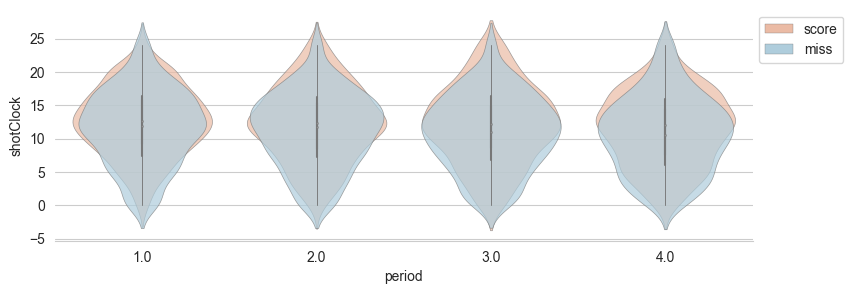

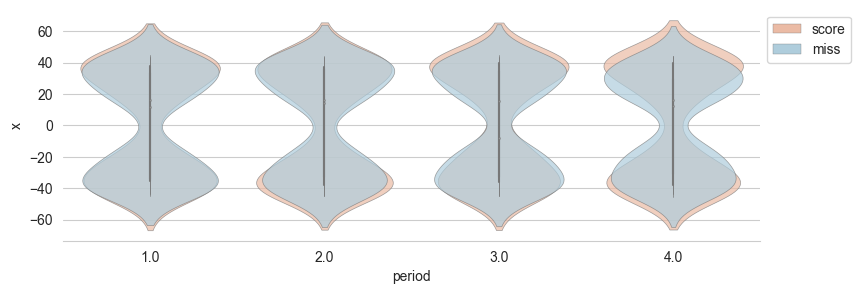

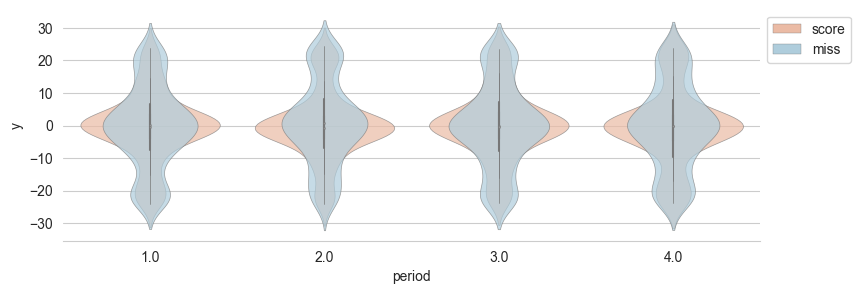

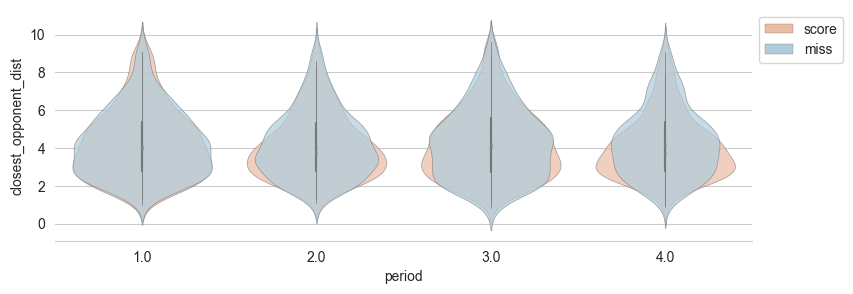

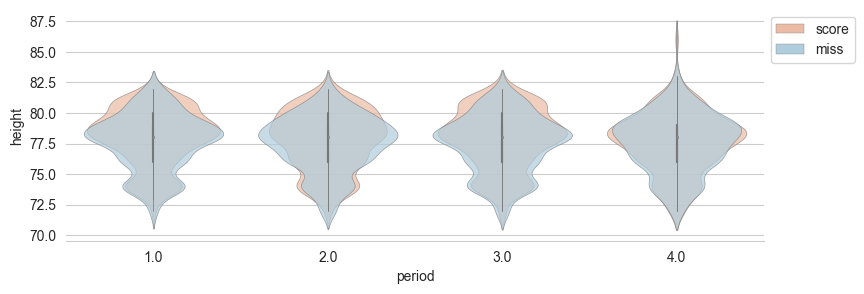

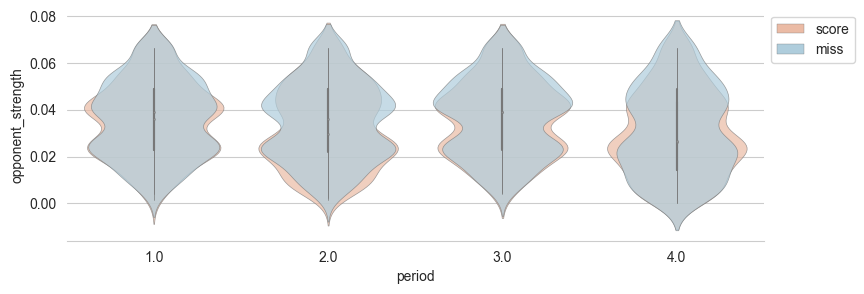

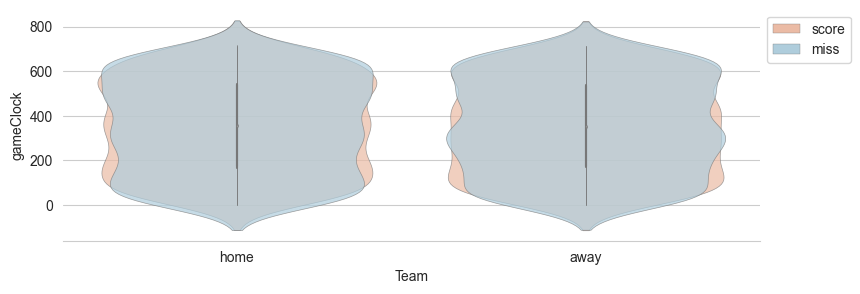

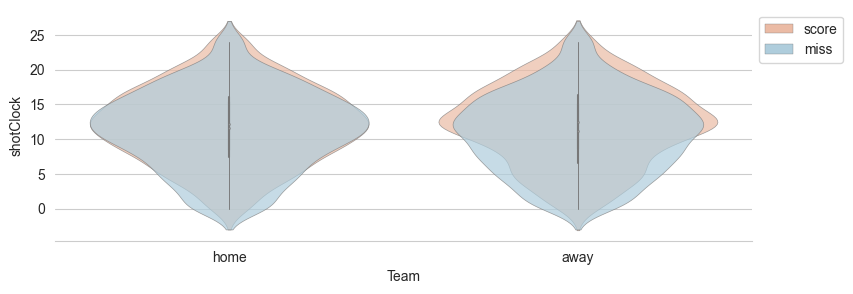

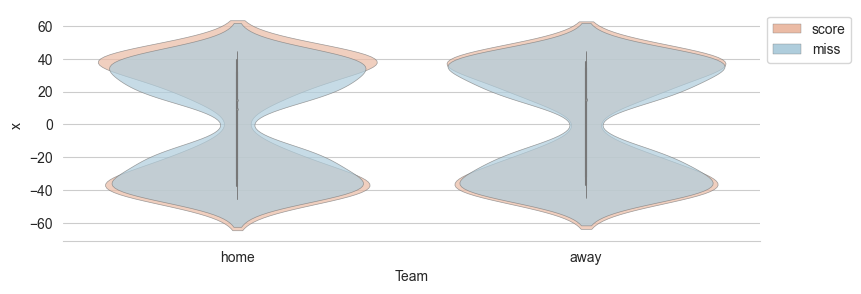

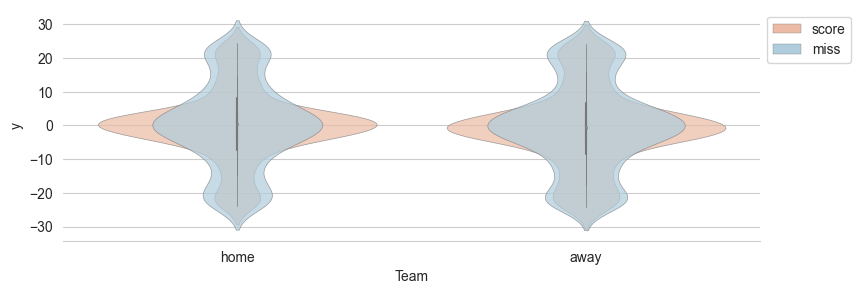

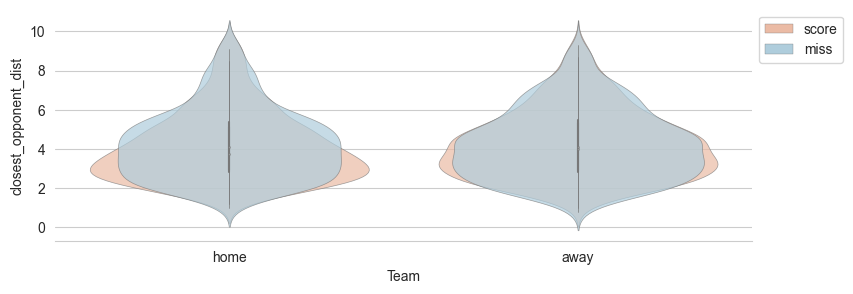

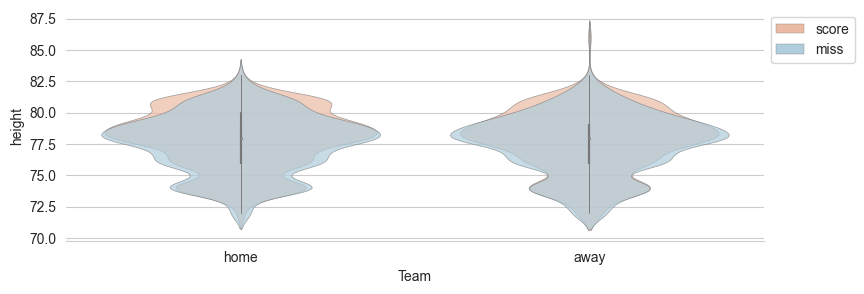

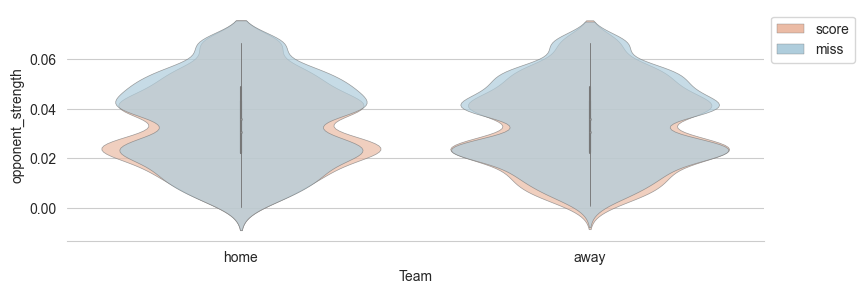

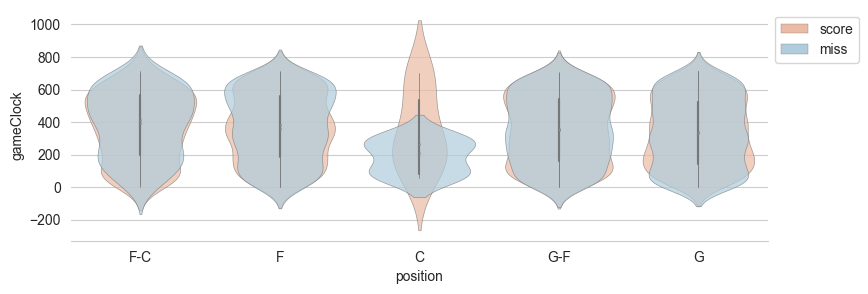

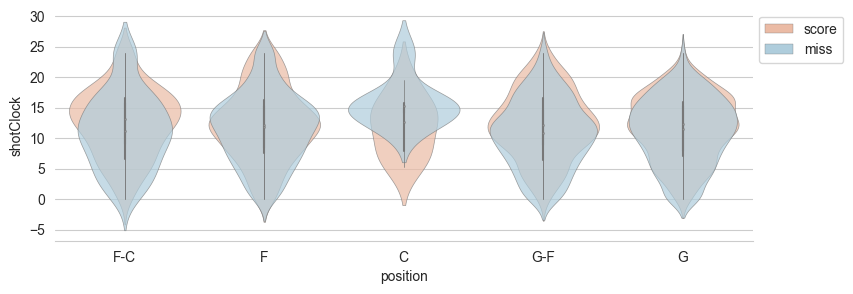

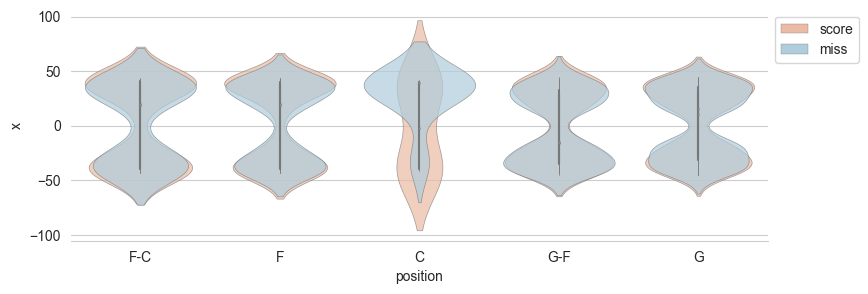

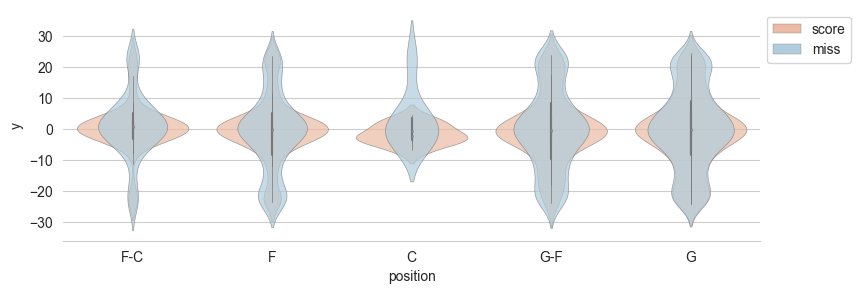

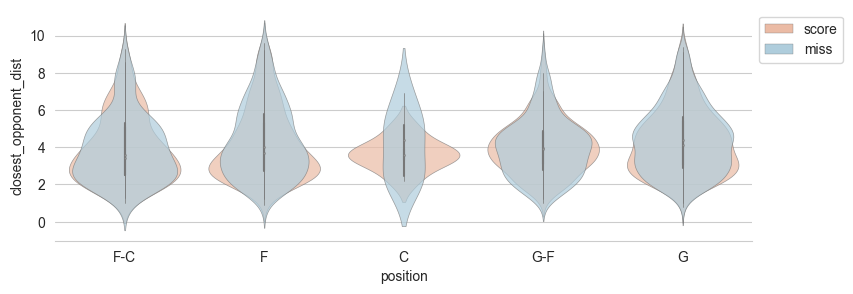

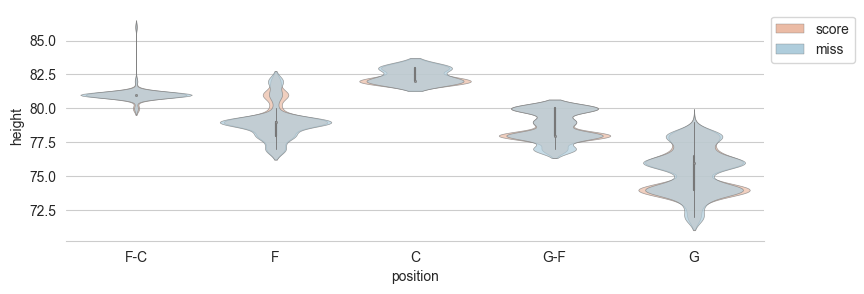

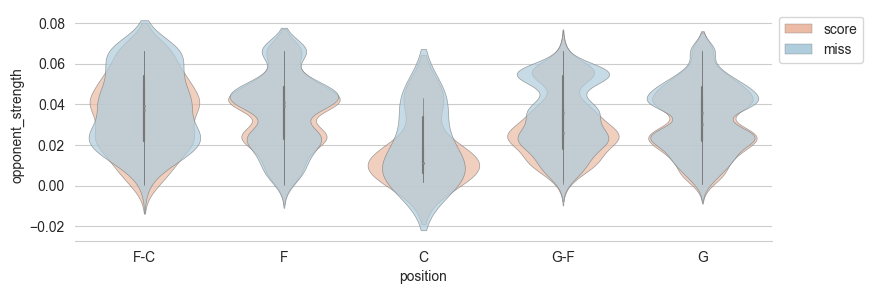

In [26]:
for cat in cat_col:
    for num in num_col:
        plt.figure(figsize=(9, 3))
        ax = sns.violinplot(y=num, x =cat, hue='score_miss', data = all_player_shots_2, palette='RdBu', dodge=False,
                           linewidth=0.5)
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=1)
        sns.despine(left=True)
        plt.setp(ax.collections, alpha=0.7)
        plt.show()

In [27]:
scored = all_player_shots[all_player_shots['score_miss'] == 'score']
missed = all_player_shots[all_player_shots['score_miss'] == 'miss']

In [28]:
def plot_paired_hist(df1, df2, col):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.distplot(df1[col], hist=True, kde=True, 
                 kde_kws={'linewidth':1, 'color': 'darkblue'}, bins=20, color='lightblue', label='score')
    sns.distplot(df2[col], hist=True, kde=True, 
                 kde_kws={'linewidth':1, 'color': 'brown'}, bins=20, color='tan', label='miss')
    plt.legend()
    plt.show()

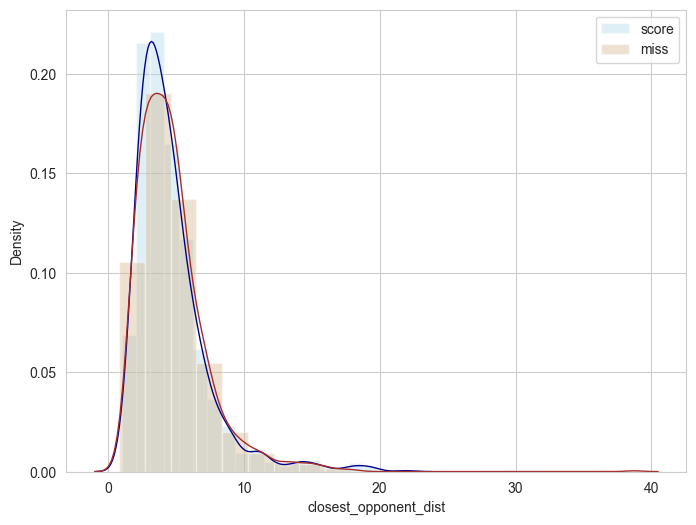

In [30]:
plot_paired_hist(scored, missed, 'closest_opponent_dist')

In [31]:
shot_types = all_player_shots['shotType'].unique()

For shot type: 2PT_SHOT


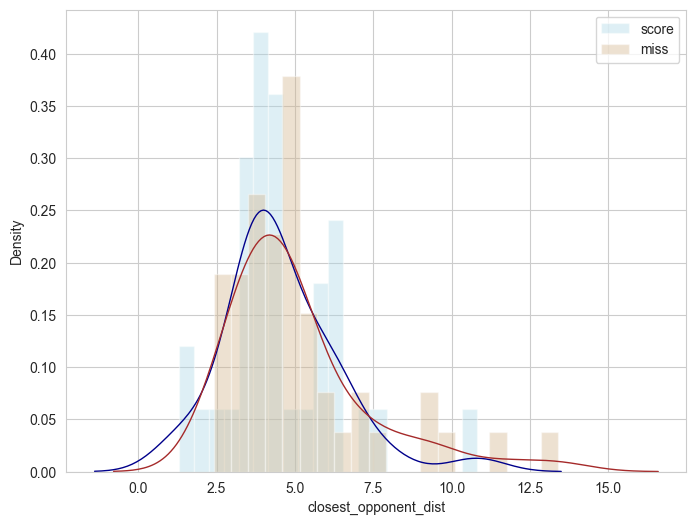

For shot type: 3PT_SHOT


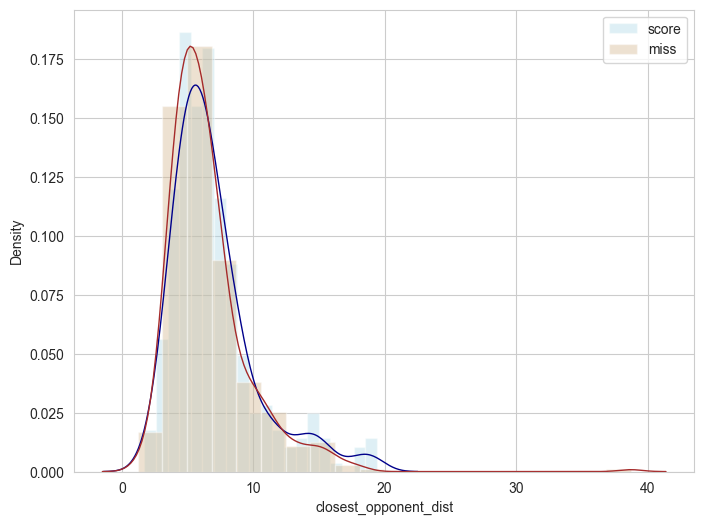

For shot type: 2PT_PAINT


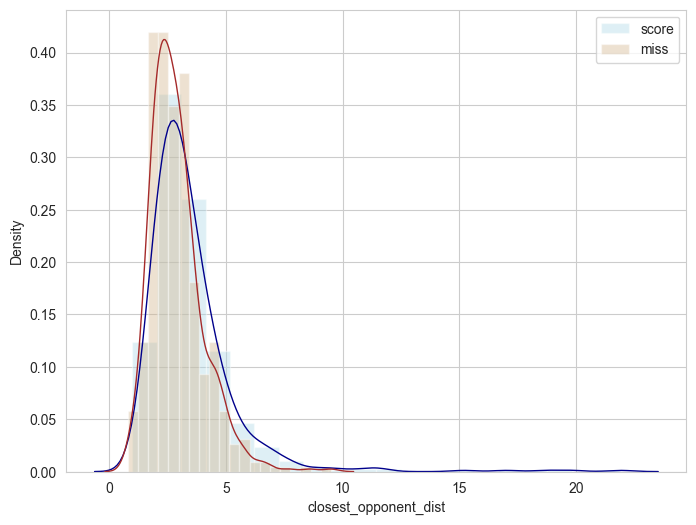

For shot type: 2PT_DRIBBLE SHOT


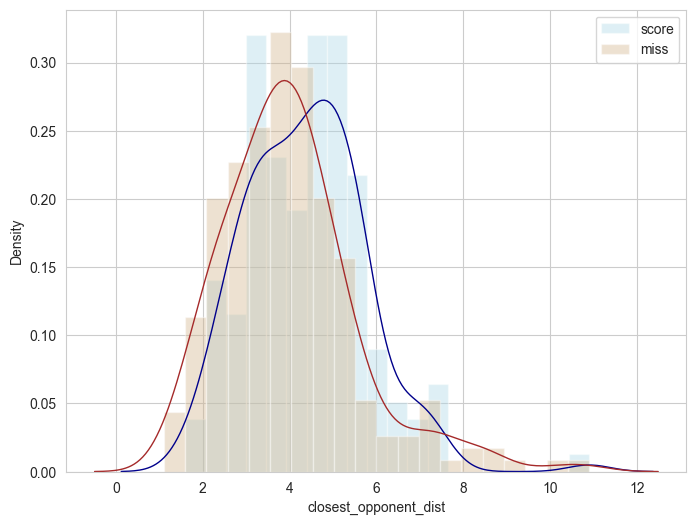

For shot type: 3PT_DRIBBLE SHOT


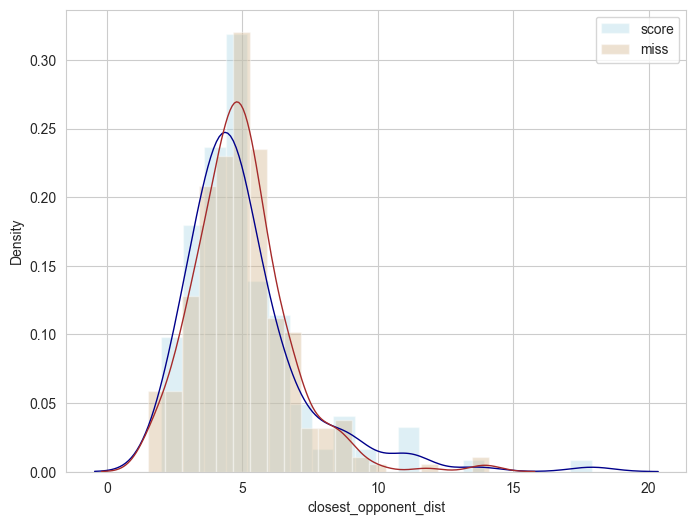

In [33]:
for shot_type in shot_types:
    df_temp = all_player_shots[all_player_shots['shotType'] == shot_type]
    scored_t = df_temp[df_temp['score_miss'] == 'score']
    missed_t = df_temp[df_temp['score_miss'] == 'miss']
    print('For shot type: '+shot_type)
    plot_paired_hist(scored_t, missed_t, 'closest_opponent_dist')

In [ ]:
plot_paired_hist(scored, missed, 'height')

In [ ]:
num_bins = 6
bin_labels = ['LL', 'L', 'LM', 'MH', 'H', 'HH']
all_player_shots['closest_opponent_dist'] = pd.qcut(all_player_shots['closest_opponent_dist'], q=num_bins, labels=bin_labels)

In [ ]:
num_bins = 6
bin_labels = ['LL', 'L', 'LM', 'MH', 'H', 'HH']
all_player_shots['height'] = pd.qcut(all_player_shots['height'], q=num_bins, labels=bin_labels)

In [ ]:
all_player_shots['closest_opponent_dist'].value_counts()

In [ ]:
all_player_shots['height'].value_counts()

In [ ]:
def plot_cat(df, cat_col):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.reshape(-1)

    for idx, col in enumerate(cat_col):
        sns.countplot(x=col, hue='score_miss', data=df, palette='Paired', ax=axes[idx])
        axes[idx].set_title('Count Plot by ' + col)
        axes[idx].set_xlabel('')

        # Annotating with percentage
        total_count = len(df[col])
        for p in axes[idx].patches:
            height = p.get_height()
            percentage = f"{100 * height / total_count:.1f}%"
            axes[idx].annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                               ha='center', va='bottom')
        axes[idx].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=1)
        axes[idx].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_cat(all_player_shots, cat_col)

In [ ]:
mapped_shots = all_player_shots.copy()

In [ ]:
mapped_shots['score_miss'] = mapped_shots['score_miss'].replace({'score': 1, 'miss': 0})

In [ ]:
mapped_shots['score_miss'].mean()

In [ ]:
mapped_shots[['shotType', 'score_miss']].groupby(['shotType'],
                                                 as_index=False).mean().sort_values(by='score_miss', ascending=False)

In [ ]:
mapped_shots[['period', 'score_miss']].groupby(['period'],
                                                 as_index=False).mean().sort_values(by='score_miss', ascending=False)

In [ ]:
mapped_shots[['Team', 'score_miss']].groupby(['Team'],
                                                 as_index=False).mean().sort_values(by='score_miss', ascending=False)

In [ ]:
mapped_shots[['position', 'score_miss']].groupby(['position'],
                                                 as_index=False).mean().sort_values(by='score_miss', ascending=False)

In [ ]:
all_player_shots_2.columns

In [ ]:
model_df = all_player_shots[['shotType', 'shotClock', 'period', 'x', 'y',
       'closest_opponent_dist', 'height', 'position', 'Team',
       'opponent_strength', 'score_miss']]

In [ ]:
model_df['score_miss'] = model_df['score_miss'].replace({'score': 1, 'miss': 0}) 

In [ ]:
model_df.dtypes

In [ ]:
model_df['shotType'] = model_df['shotType'].astype('category')
model_df['score_miss'] = model_df['score_miss'].astype('category')
model_df['period'] = model_df['period'].astype('category')
model_df['position'] = model_df['position'].astype('category')
model_df['height'] = model_df['height'].astype('category')

In [ ]:
model_df.dtypes

In [ ]:
dummy_cols = ['shotType', 'period', 'position', 'Team', 'height']

In [ ]:
def get_dummy(df, dummy_cols):
    for col in dummy_cols:
        dummy = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        df = pd.concat([df, dummy], axis=1)
    df.drop(dummy_cols, axis = 1, inplace = True)
    return df

In [ ]:
model_df_2 = get_dummy(model_df, dummy_cols)

In [ ]:
model_df_2.head()

In [ ]:
lr_pipeline = Pipeline([('lr', LogisticRegression())])

rf_pipeline = Pipeline([('rf', RandomForestClassifier())])

nb_pipeline = Pipeline([('nb', GaussianNB())])

xgb_pipeline = Pipeline([('xgb', XGBClassifier())])

pipelines = [lr_pipeline, rf_pipeline, nb_pipeline, xgb_pipeline]

In [ ]:
def metrics_display(model, df, target):
    '''display model performence metrics'''
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], test_size=0.25, 
                                                    random_state=47)    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  

In [ ]:
def modeling(df, target, scale = True):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], test_size=0.25, 
                                                    random_state=47)
    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    else: 
        pass
    
    #oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    #X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    highest_accuracy = 0.0
    best_pipeline = None

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_name = pipeline.steps[-1][1].__class__.__name__
        print(f'{model_name} Accuracy: {accuracy:.2f}')

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_pipeline = pipeline   
        else: pass
        
    print(' ')
    print('Best model: ' + best_pipeline.steps[-1][1].__class__.__name__)
    metrics_display(best_pipeline, df, target)

In [ ]:
modeling(model_df_2, 'score_miss')

In [ ]:
modeling(model_df_2, 'score_miss', scale = False)

In [ ]:
def logistic_Grid_CV(df, target):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)

    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test= scaler.transform(X_test)
    
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    param_grid = {
        'C': [0.01, 0.1, 0.5, 1.0, 10.0],  
        'penalty': ['l1', 'l2'],           
        'solver': ['liblinear', 'saga'],   
        'max_iter': [100, 500, 1000]       
    }
    
    logistic_model = LogisticRegression() 
    grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring=make_scorer(accuracy_score))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    best_logistic_model = grid_search.best_estimator_

    y_pred = best_logistic_model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_logistic_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logistic_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  

In [ ]:
logistic_Grid_CV(model_df_2, 'score_miss')

In [ ]:
def rf_Grid_CV(df, target):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    param_grid = {
        'n_estimators': [100, 200, 300],             # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],             # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4]                # Minimum number of samples required to be at a leaf node
    }
    
    rf_model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=make_scorer(accuracy_score))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    best_rf_model = grid_search.best_estimator_

    y_pred = best_rf_model.predict(X_test)
    feature_importances = best_rf_model.feature_importances_
    features = X_train.columns
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_rf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  
    
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sorted_feature_importance_df = sorted_feature_importance_df.reset_index(drop = True)
    print(sorted_feature_importance_df)

    plt.figure(figsize=(8, 5))
    plt.bar(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color = 'lavender')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances in Random Forest (Best Model)')
    plt.tight_layout()
    plt.show()
    
    return best_rf_model, feature_importances

In [ ]:
best_model, feature_importances = rf_Grid_CV(model_df_2, 'score_miss')

In [ ]:
model_df_3 = model_df_2[['y', 'x', 'shotType_2PT_PAINT','Team_home', 'opponent_strength', 'score_miss']]

In [ ]:
rf_Grid_CV(model_df_3, 'score_miss')

In [ ]:
#joblib.dump(model, 'new_data/saved_model.pkl')